In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [9]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [10]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [11]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [12]:
from diffusers import DEISMultistepScheduler

In [19]:
scheduler = DEISMultistepScheduler( num_train_timesteps=150, beta_end=0.1, )

estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=10,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="auto"),
)

In [20]:
predictor = estimator.train(dataset_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\chanyoung\anaconda3\envs\coolingts\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | In sizes | Out sizes        
-----------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | ?        | [1, 100, 24, 370]
-----------------------------------------------------------------------
432 K     Trainable params
0         Non-trainable params
432 K     Total params
1.729     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.413]

Epoch 0, global step 50: 'train_loss' reached 0.41286 (best 0.41286), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:26<00:00,  1.90it/s, v_num=15, train_loss=0.256]

Epoch 1, global step 100: 'train_loss' reached 0.25553 (best 0.25553), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:28<00:00,  1.78it/s, v_num=15, train_loss=0.145]

Epoch 2, global step 150: 'train_loss' reached 0.14452 (best 0.14452), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:26<00:00,  1.86it/s, v_num=15, train_loss=0.119]

Epoch 3, global step 200: 'train_loss' reached 0.11948 (best 0.11948), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.112]

Epoch 4, global step 250: 'train_loss' reached 0.11231 (best 0.11231), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:26<00:00,  1.86it/s, v_num=15, train_loss=0.106]

Epoch 5, global step 300: 'train_loss' reached 0.10637 (best 0.10637), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:26<00:00,  1.86it/s, v_num=15, train_loss=0.102]

Epoch 6, global step 350: 'train_loss' reached 0.10229 (best 0.10229), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0981]

Epoch 7, global step 400: 'train_loss' reached 0.09808 (best 0.09808), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0955]

Epoch 8, global step 450: 'train_loss' reached 0.09548 (best 0.09548), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0925]

Epoch 9, global step 500: 'train_loss' reached 0.09246 (best 0.09246), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:26<00:00,  1.87it/s, v_num=15, train_loss=0.0893]

Epoch 10, global step 550: 'train_loss' reached 0.08929 (best 0.08929), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0888]

Epoch 11, global step 600: 'train_loss' reached 0.08884 (best 0.08884), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0863]

Epoch 12, global step 650: 'train_loss' reached 0.08628 (best 0.08628), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0842]

Epoch 13, global step 700: 'train_loss' reached 0.08421 (best 0.08421), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:26<00:00,  1.89it/s, v_num=15, train_loss=0.0843]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0826]

Epoch 15, global step 800: 'train_loss' reached 0.08265 (best 0.08265), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:26<00:00,  1.90it/s, v_num=15, train_loss=0.081] 

Epoch 16, global step 850: 'train_loss' reached 0.08100 (best 0.08100), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0808]

Epoch 17, global step 900: 'train_loss' reached 0.08082 (best 0.08082), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0797]

Epoch 18, global step 950: 'train_loss' reached 0.07968 (best 0.07968), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0787]

Epoch 19, global step 1000: 'train_loss' reached 0.07866 (best 0.07866), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0787]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:26<00:00,  1.89it/s, v_num=15, train_loss=0.0778]

Epoch 21, global step 1100: 'train_loss' reached 0.07785 (best 0.07785), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:27<00:00,  1.83it/s, v_num=15, train_loss=0.0769]

Epoch 22, global step 1150: 'train_loss' reached 0.07685 (best 0.07685), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0769]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0758]

Epoch 24, global step 1250: 'train_loss' reached 0.07576 (best 0.07576), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0752]

Epoch 25, global step 1300: 'train_loss' reached 0.07522 (best 0.07522), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0752]

Epoch 26, global step 1350: 'train_loss' reached 0.07521 (best 0.07521), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0747]

Epoch 27, global step 1400: 'train_loss' reached 0.07467 (best 0.07467), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:26<00:00,  1.90it/s, v_num=15, train_loss=0.0742]

Epoch 28, global step 1450: 'train_loss' reached 0.07416 (best 0.07416), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0745]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0729]

Epoch 30, global step 1550: 'train_loss' reached 0.07294 (best 0.07294), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0733]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0721]

Epoch 32, global step 1650: 'train_loss' reached 0.07207 (best 0.07207), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=32-step=1650.ckpt' as top 1


Epoch 33: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.072] 

Epoch 33, global step 1700: 'train_loss' reached 0.07200 (best 0.07200), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0717]

Epoch 34, global step 1750: 'train_loss' reached 0.07172 (best 0.07172), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0708]

Epoch 35, global step 1800: 'train_loss' reached 0.07083 (best 0.07083), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0724]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0717]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0706]

Epoch 38, global step 1950: 'train_loss' reached 0.07058 (best 0.07058), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0695]

Epoch 39, global step 2000: 'train_loss' reached 0.06951 (best 0.06951), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0702]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:24<00:00,  2.08it/s, v_num=15, train_loss=0.069] 

Epoch 41, global step 2100: 'train_loss' reached 0.06898 (best 0.06898), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.070]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0699]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.069] 

Epoch 44, global step 2250: 'train_loss' reached 0.06896 (best 0.06896), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=44-step=2250.ckpt' as top 1


Epoch 45: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0691]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0697]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:25<00:00,  1.92it/s, v_num=15, train_loss=0.0682]

Epoch 47, global step 2400: 'train_loss' reached 0.06819 (best 0.06819), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0682]

Epoch 48, global step 2450: 'train_loss' reached 0.06818 (best 0.06818), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0682]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0686]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0686]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0676]

Epoch 52, global step 2650: 'train_loss' reached 0.06762 (best 0.06762), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=52-step=2650.ckpt' as top 1


Epoch 53: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0682]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:24<00:00,  2.01it/s, v_num=15, train_loss=0.0667]

Epoch 54, global step 2750: 'train_loss' reached 0.06668 (best 0.06668), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0667]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0673]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0663]

Epoch 57, global step 2900: 'train_loss' reached 0.06630 (best 0.06630), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=57-step=2900.ckpt' as top 1


Epoch 58: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0664]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0673]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:26<00:00,  1.91it/s, v_num=15, train_loss=0.0662]

Epoch 60, global step 3050: 'train_loss' reached 0.06625 (best 0.06625), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=60-step=3050.ckpt' as top 1


Epoch 61: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0673]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:24<00:00,  2.07it/s, v_num=15, train_loss=0.066] 

Epoch 62, global step 3150: 'train_loss' reached 0.06604 (best 0.06604), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [00:24<00:00,  2.01it/s, v_num=15, train_loss=0.0656]

Epoch 63, global step 3200: 'train_loss' reached 0.06560 (best 0.06560), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=63-step=3200.ckpt' as top 1


Epoch 64: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0663]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0657]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0652]

Epoch 66, global step 3350: 'train_loss' reached 0.06517 (best 0.06517), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=66-step=3350.ckpt' as top 1


Epoch 67: |          | 50/? [00:24<00:00,  2.01it/s, v_num=15, train_loss=0.0652]

Epoch 67, global step 3400: 'train_loss' reached 0.06515 (best 0.06515), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=67-step=3400.ckpt' as top 1


Epoch 68: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0649]

Epoch 68, global step 3450: 'train_loss' reached 0.06486 (best 0.06486), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=68-step=3450.ckpt' as top 1


Epoch 69: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.065] 

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0673]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.065] 

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.065]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0642]

Epoch 73, global step 3700: 'train_loss' reached 0.06424 (best 0.06424), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=73-step=3700.ckpt' as top 1


Epoch 74: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0645]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.0644]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0634]

Epoch 76, global step 3850: 'train_loss' reached 0.06344 (best 0.06344), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=76-step=3850.ckpt' as top 1


Epoch 77: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0643]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0636]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0638]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.064] 

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0637]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0638]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0635]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |          | 50/? [00:24<00:00,  2.08it/s, v_num=15, train_loss=0.0641]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0649]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0641]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0634]

Epoch 87, global step 4400: 'train_loss' reached 0.06339 (best 0.06339), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=87-step=4400.ckpt' as top 1


Epoch 88: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0637]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.063] 

Epoch 89, global step 4500: 'train_loss' reached 0.06305 (best 0.06305), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=89-step=4500.ckpt' as top 1


Epoch 90: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0632]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0631]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0626]

Epoch 92, global step 4650: 'train_loss' reached 0.06259 (best 0.06259), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=92-step=4650.ckpt' as top 1


Epoch 93: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0629]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0631]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [00:26<00:00,  1.92it/s, v_num=15, train_loss=0.0625]

Epoch 95, global step 4800: 'train_loss' reached 0.06253 (best 0.06253), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=95-step=4800.ckpt' as top 1


Epoch 96: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0624]

Epoch 96, global step 4850: 'train_loss' reached 0.06240 (best 0.06240), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=96-step=4850.ckpt' as top 1


Epoch 97: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.063] 

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:24<00:00,  2.01it/s, v_num=15, train_loss=0.0622]

Epoch 98, global step 4950: 'train_loss' reached 0.06222 (best 0.06222), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=98-step=4950.ckpt' as top 1


Epoch 99: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0627]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0624]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.062] 

Epoch 101, global step 5100: 'train_loss' reached 0.06198 (best 0.06198), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=101-step=5100.ckpt' as top 1


Epoch 102: |          | 50/? [00:26<00:00,  1.92it/s, v_num=15, train_loss=0.0625]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0621]

Epoch 103, global step 5200: 'train_loss' was not in top 1


Epoch 104: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0624]

Epoch 104, global step 5250: 'train_loss' was not in top 1


Epoch 105: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0616]

Epoch 105, global step 5300: 'train_loss' reached 0.06157 (best 0.06157), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=105-step=5300.ckpt' as top 1


Epoch 106: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0613]

Epoch 106, global step 5350: 'train_loss' reached 0.06133 (best 0.06133), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=106-step=5350.ckpt' as top 1


Epoch 107: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0615]

Epoch 107, global step 5400: 'train_loss' was not in top 1


Epoch 108: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0612]

Epoch 108, global step 5450: 'train_loss' reached 0.06119 (best 0.06119), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=108-step=5450.ckpt' as top 1


Epoch 109: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.062] 

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0617]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0607]

Epoch 111, global step 5600: 'train_loss' reached 0.06073 (best 0.06073), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=111-step=5600.ckpt' as top 1


Epoch 112: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0612]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0615]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0609]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.0611]

Epoch 115, global step 5800: 'train_loss' was not in top 1


Epoch 116: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0607]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.061] 

Epoch 117, global step 5900: 'train_loss' was not in top 1


Epoch 118: |          | 50/? [00:25<00:00,  1.95it/s, v_num=15, train_loss=0.0613]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0611]

Epoch 119, global step 6000: 'train_loss' was not in top 1


Epoch 120: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0614]

Epoch 120, global step 6050: 'train_loss' was not in top 1


Epoch 121: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0601]

Epoch 121, global step 6100: 'train_loss' reached 0.06012 (best 0.06012), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=121-step=6100.ckpt' as top 1


Epoch 122: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0606]

Epoch 122, global step 6150: 'train_loss' was not in top 1


Epoch 123: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0611]

Epoch 123, global step 6200: 'train_loss' was not in top 1


Epoch 124: |          | 50/? [00:24<00:00,  2.07it/s, v_num=15, train_loss=0.0601]

Epoch 124, global step 6250: 'train_loss' was not in top 1


Epoch 125: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0602]

Epoch 125, global step 6300: 'train_loss' was not in top 1


Epoch 126: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0599]

Epoch 126, global step 6350: 'train_loss' reached 0.05995 (best 0.05995), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=126-step=6350.ckpt' as top 1


Epoch 127: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0602]

Epoch 127, global step 6400: 'train_loss' was not in top 1


Epoch 128: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.060] 

Epoch 128, global step 6450: 'train_loss' was not in top 1


Epoch 129: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0596]

Epoch 129, global step 6500: 'train_loss' reached 0.05963 (best 0.05963), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=129-step=6500.ckpt' as top 1


Epoch 130: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0598]

Epoch 130, global step 6550: 'train_loss' was not in top 1


Epoch 131: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0603]

Epoch 131, global step 6600: 'train_loss' was not in top 1


Epoch 132: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0594]

Epoch 132, global step 6650: 'train_loss' reached 0.05944 (best 0.05944), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=132-step=6650.ckpt' as top 1


Epoch 133: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0609]

Epoch 133, global step 6700: 'train_loss' was not in top 1


Epoch 134: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0601]

Epoch 134, global step 6750: 'train_loss' was not in top 1


Epoch 135: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0675]

Epoch 135, global step 6800: 'train_loss' was not in top 1


Epoch 136: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0639]

Epoch 136, global step 6850: 'train_loss' was not in top 1


Epoch 137: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.0603]

Epoch 137, global step 6900: 'train_loss' was not in top 1


Epoch 138: |          | 50/? [00:23<00:00,  2.11it/s, v_num=15, train_loss=0.0599]

Epoch 138, global step 6950: 'train_loss' was not in top 1


Epoch 139: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0598]

Epoch 139, global step 7000: 'train_loss' was not in top 1


Epoch 140: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0599]

Epoch 140, global step 7050: 'train_loss' was not in top 1


Epoch 141: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0598]

Epoch 141, global step 7100: 'train_loss' was not in top 1


Epoch 142: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0606]

Epoch 142, global step 7150: 'train_loss' was not in top 1


Epoch 143: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0598]

Epoch 143, global step 7200: 'train_loss' was not in top 1


Epoch 144: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0591]

Epoch 144, global step 7250: 'train_loss' reached 0.05911 (best 0.05911), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=144-step=7250.ckpt' as top 1


Epoch 145: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0591]

Epoch 145, global step 7300: 'train_loss' was not in top 1


Epoch 146: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0584]

Epoch 146, global step 7350: 'train_loss' reached 0.05839 (best 0.05839), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=146-step=7350.ckpt' as top 1


Epoch 147: |          | 50/? [00:26<00:00,  1.92it/s, v_num=15, train_loss=0.0593]

Epoch 147, global step 7400: 'train_loss' was not in top 1


Epoch 148: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0582]

Epoch 148, global step 7450: 'train_loss' reached 0.05825 (best 0.05825), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=148-step=7450.ckpt' as top 1


Epoch 149: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0588]

Epoch 149, global step 7500: 'train_loss' was not in top 1


Epoch 150: |          | 50/? [00:25<00:00,  1.93it/s, v_num=15, train_loss=0.0586]

Epoch 150, global step 7550: 'train_loss' was not in top 1


Epoch 151: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0584]

Epoch 151, global step 7600: 'train_loss' was not in top 1


Epoch 152: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.0582]

Epoch 152, global step 7650: 'train_loss' reached 0.05818 (best 0.05818), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=152-step=7650.ckpt' as top 1


Epoch 153: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.0585]

Epoch 153, global step 7700: 'train_loss' was not in top 1


Epoch 154: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.059] 

Epoch 154, global step 7750: 'train_loss' was not in top 1


Epoch 155: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.0584]

Epoch 155, global step 7800: 'train_loss' was not in top 1


Epoch 156: |          | 50/? [00:24<00:00,  2.08it/s, v_num=15, train_loss=0.0582]

Epoch 156, global step 7850: 'train_loss' was not in top 1


Epoch 157: |          | 50/? [00:25<00:00,  1.99it/s, v_num=15, train_loss=0.0587]

Epoch 157, global step 7900: 'train_loss' was not in top 1


Epoch 158: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0587]

Epoch 158, global step 7950: 'train_loss' was not in top 1


Epoch 159: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0582]

Epoch 159, global step 8000: 'train_loss' reached 0.05815 (best 0.05815), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=159-step=8000.ckpt' as top 1


Epoch 160: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0582]

Epoch 160, global step 8050: 'train_loss' was not in top 1


Epoch 161: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0591]

Epoch 161, global step 8100: 'train_loss' was not in top 1


Epoch 162: |          | 50/? [00:23<00:00,  2.11it/s, v_num=15, train_loss=0.0583]

Epoch 162, global step 8150: 'train_loss' was not in top 1


Epoch 163: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0581]

Epoch 163, global step 8200: 'train_loss' reached 0.05815 (best 0.05815), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=163-step=8200.ckpt' as top 1


Epoch 164: |          | 50/? [00:23<00:00,  2.14it/s, v_num=15, train_loss=0.0581]

Epoch 164, global step 8250: 'train_loss' reached 0.05805 (best 0.05805), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=164-step=8250.ckpt' as top 1


Epoch 165: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0585]

Epoch 165, global step 8300: 'train_loss' was not in top 1


Epoch 166: |          | 50/? [00:23<00:00,  2.16it/s, v_num=15, train_loss=0.058] 

Epoch 166, global step 8350: 'train_loss' reached 0.05801 (best 0.05801), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=166-step=8350.ckpt' as top 1


Epoch 167: |          | 50/? [00:25<00:00,  1.97it/s, v_num=15, train_loss=0.0583]

Epoch 167, global step 8400: 'train_loss' was not in top 1


Epoch 168: |          | 50/? [00:24<00:00,  2.07it/s, v_num=15, train_loss=0.0578]

Epoch 168, global step 8450: 'train_loss' reached 0.05784 (best 0.05784), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=168-step=8450.ckpt' as top 1


Epoch 169: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0581]

Epoch 169, global step 8500: 'train_loss' was not in top 1


Epoch 170: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0583]

Epoch 170, global step 8550: 'train_loss' was not in top 1


Epoch 171: |          | 50/? [00:24<00:00,  2.06it/s, v_num=15, train_loss=0.0581]

Epoch 171, global step 8600: 'train_loss' was not in top 1


Epoch 172: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0579]

Epoch 172, global step 8650: 'train_loss' was not in top 1


Epoch 173: |          | 50/? [00:25<00:00,  1.94it/s, v_num=15, train_loss=0.058] 

Epoch 173, global step 8700: 'train_loss' was not in top 1


Epoch 174: |          | 50/? [00:24<00:00,  2.00it/s, v_num=15, train_loss=0.0577]

Epoch 174, global step 8750: 'train_loss' reached 0.05770 (best 0.05770), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=174-step=8750.ckpt' as top 1


Epoch 175: |          | 50/? [00:24<00:00,  2.08it/s, v_num=15, train_loss=0.0581]

Epoch 175, global step 8800: 'train_loss' was not in top 1


Epoch 176: |          | 50/? [00:24<00:00,  2.07it/s, v_num=15, train_loss=0.0579]

Epoch 176, global step 8850: 'train_loss' was not in top 1


Epoch 177: |          | 50/? [00:23<00:00,  2.10it/s, v_num=15, train_loss=0.0579]

Epoch 177, global step 8900: 'train_loss' was not in top 1


Epoch 178: |          | 50/? [00:23<00:00,  2.08it/s, v_num=15, train_loss=0.0578]

Epoch 178, global step 8950: 'train_loss' was not in top 1


Epoch 179: |          | 50/? [00:25<00:00,  1.96it/s, v_num=15, train_loss=0.058] 

Epoch 179, global step 9000: 'train_loss' was not in top 1


Epoch 180: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.0578]

Epoch 180, global step 9050: 'train_loss' was not in top 1


Epoch 181: |          | 50/? [00:24<00:00,  2.07it/s, v_num=15, train_loss=0.0577]

Epoch 181, global step 9100: 'train_loss' was not in top 1


Epoch 182: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.057] 

Epoch 182, global step 9150: 'train_loss' reached 0.05699 (best 0.05699), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=182-step=9150.ckpt' as top 1


Epoch 183: |          | 50/? [00:25<00:00,  2.00it/s, v_num=15, train_loss=0.0574]

Epoch 183, global step 9200: 'train_loss' was not in top 1


Epoch 184: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0575]

Epoch 184, global step 9250: 'train_loss' was not in top 1


Epoch 185: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.058] 

Epoch 185, global step 9300: 'train_loss' was not in top 1


Epoch 186: |          | 50/? [00:23<00:00,  2.09it/s, v_num=15, train_loss=0.0573]

Epoch 186, global step 9350: 'train_loss' was not in top 1


Epoch 187: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.058] 

Epoch 187, global step 9400: 'train_loss' was not in top 1


Epoch 188: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0577]

Epoch 188, global step 9450: 'train_loss' was not in top 1


Epoch 189: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.0574]

Epoch 189, global step 9500: 'train_loss' was not in top 1


Epoch 190: |          | 50/? [00:25<00:00,  1.98it/s, v_num=15, train_loss=0.0572]

Epoch 190, global step 9550: 'train_loss' was not in top 1


Epoch 191: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0579]

Epoch 191, global step 9600: 'train_loss' was not in top 1


Epoch 192: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.057] 

Epoch 192, global step 9650: 'train_loss' was not in top 1


Epoch 193: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0582]

Epoch 193, global step 9700: 'train_loss' was not in top 1


Epoch 194: |          | 50/? [00:24<00:00,  2.03it/s, v_num=15, train_loss=0.0573]

Epoch 194, global step 9750: 'train_loss' was not in top 1


Epoch 195: |          | 50/? [00:24<00:00,  2.02it/s, v_num=15, train_loss=0.057] 

Epoch 195, global step 9800: 'train_loss' was not in top 1


Epoch 196: |          | 50/? [00:23<00:00,  2.08it/s, v_num=15, train_loss=0.0574]

Epoch 196, global step 9850: 'train_loss' was not in top 1


Epoch 197: |          | 50/? [00:24<00:00,  2.04it/s, v_num=15, train_loss=0.0564]

Epoch 197, global step 9900: 'train_loss' reached 0.05643 (best 0.05643), saving model to 'c:\\Users\\chanyoung\\Desktop\\새 폴더 (2)\\lightning_logs\\version_15\\checkpoints\\epoch=197-step=9900.ckpt' as top 1


Epoch 198: |          | 50/? [00:24<00:00,  2.05it/s, v_num=15, train_loss=0.057] 

Epoch 198, global step 9950: 'train_loss' was not in top 1


Epoch 199: |          | 50/? [00:23<00:00,  2.09it/s, v_num=15, train_loss=0.0565]

Epoch 199, global step 10000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: |          | 50/? [00:23<00:00,  2.09it/s, v_num=15, train_loss=0.0565]


In [24]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [25]:

forecasts = list(forecast_it)
targets = list(ts_it)

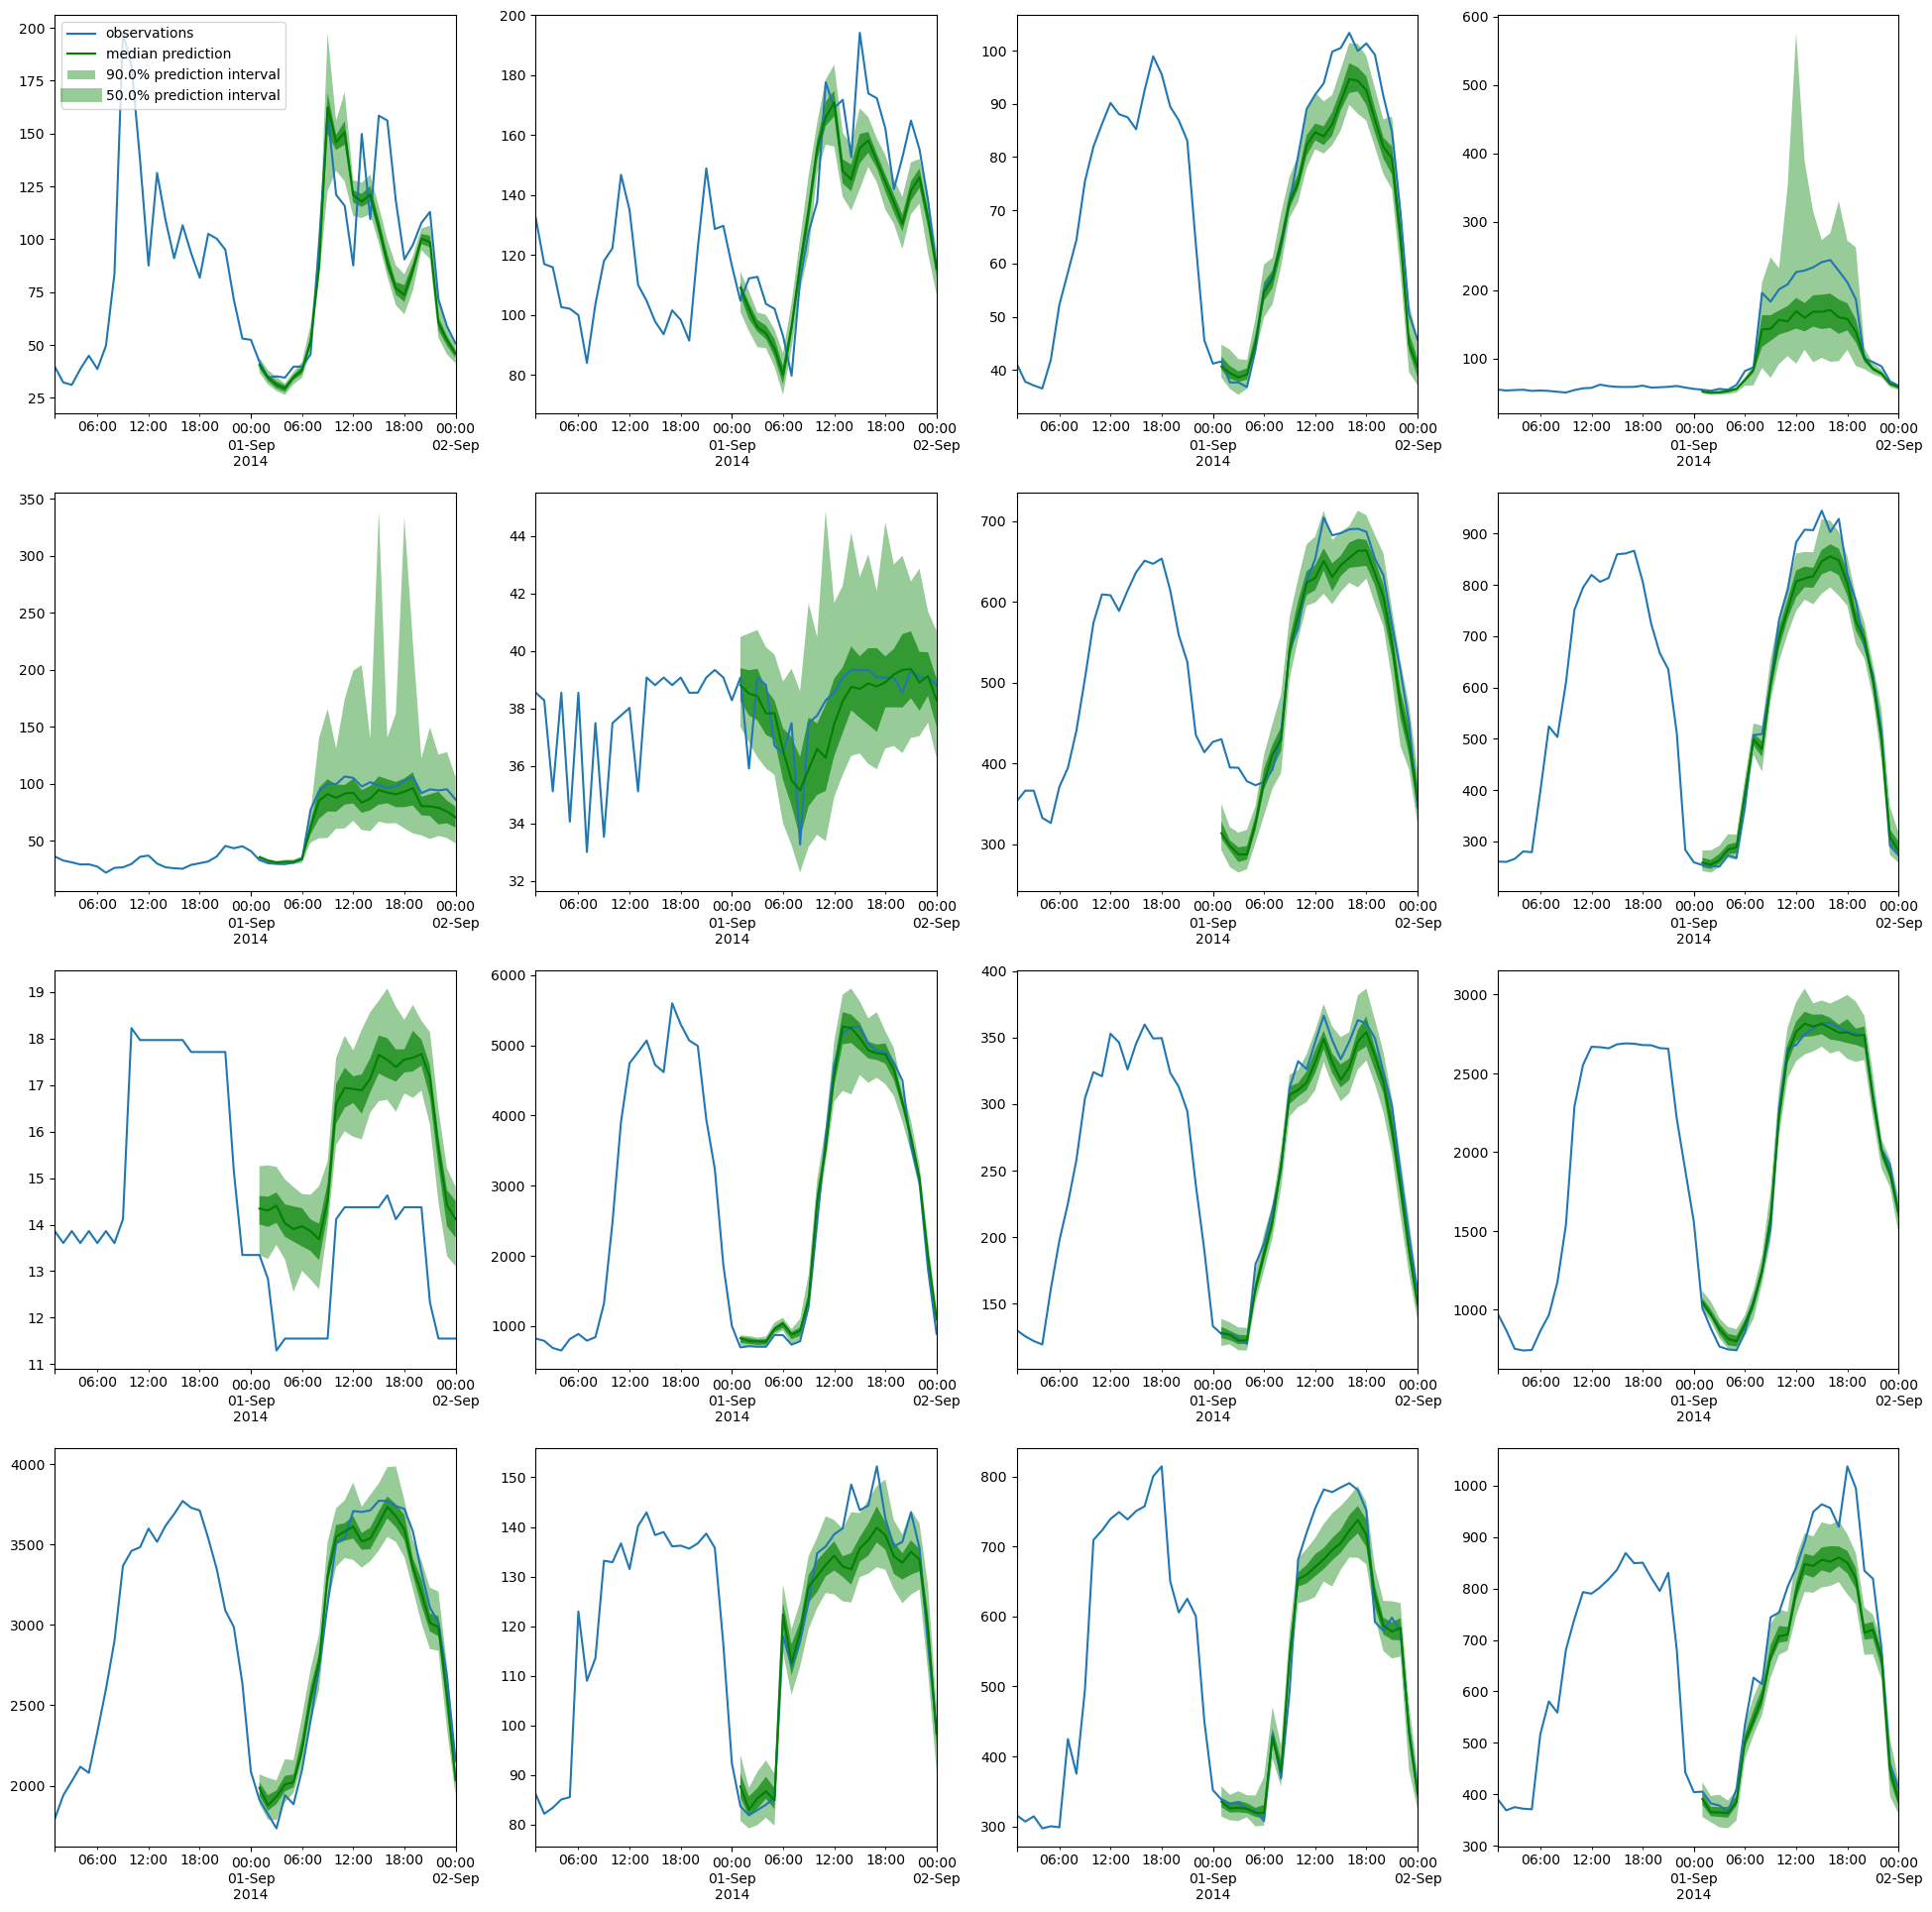

In [26]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [27]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [28]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 77.08it/s]
Running evaluation: 7it [00:00, 75.27it/s]
Running evaluation: 7it [00:00, 80.31it/s]
Running evaluation: 7it [00:00, 88.62it/s]
Running evaluation: 7it [00:00, 59.33it/s]
Running evaluation: 7it [00:00, 81.50it/s]
Running evaluation: 7it [00:00, 72.19it/s]
Running evaluation: 7it [00:00, 77.80it/s]
Running evaluation: 7it [00:00, 59.34it/s]
Running evaluation: 7it [00:00, 84.36it/s]
Running evaluation: 7it [00:00, 69.12it/s]
Running evaluation: 7it [00:00, 63.08it/s]
Running evaluation: 7it [00:00, 64.24it/s]
Running evaluation: 7it [00:00, 64.24it/s]
Running evaluation: 7it [00:00, 70.02it/s]
Running evaluation: 7it [00:00, 72.17it/s]
Running evaluation: 7it [00:00, 75.29it/s]
Running evaluation: 7it [00:00, 65.44it/s]
Running evaluation: 7it [00:00, 82.38it/s]
Running evaluation: 7it [00:00, 66.69it/s]
Running evaluation: 7it [00:00, 55.14it/s]
Running evaluation: 7it [00:00, 56.46it/s]
Running evaluation: 7it [00:00, 61.43it/s]
Running eva

In [29]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.05148147785351012
ND: 0.06489031597949381
NRMSE: 0.7785611232374716

CRPS-Sum: 0.021399795121205146
ND-Sum: 0.027370773822510918
NRMSE-Sum: 0.05424623720612409
